# Стартапы

### Описание

Исследование посвящено данными о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо предсказать, какие из них закроются.

В ходе работы необходимо выполнить следующее:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

### Импорт библиотек

In [1]:
!pip install phik -q
!pip install lightgbm -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from phik.report import plot_correlation_matrix
from phik import report

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb

### Загрузка данных

In [3]:
def primary_information(df):
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [4]:
startups_train = pd.read_csv('data/kaggle_startups_train_27042024.csv')
startups_test = pd.read_csv('data/kaggle_startups_test_27042024.csv')

In [5]:
primary_information(startups_train)
primary_information(startups_test)

Размерность: (52514, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN


Размерность: (13125, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


### Приведем поля с датой к соответствующему типу данных

In [6]:
def cast_datetime(df):
    df['founded_at'] = pd.to_datetime(
        df['founded_at'], format="%Y-%m-%d"
    )
    df['first_funding_at'] = pd.to_datetime(
        df['first_funding_at'], format="%Y-%m-%d"
    )
    df['last_funding_at'] = pd.to_datetime(
        df['last_funding_at'], format="%Y-%m-%d"
    )

In [7]:
cast_datetime(startups_train)
cast_datetime(startups_test)

# Пропущенные значения в поле closed_at означают, что стартап не закрыт, поэтому заполним текущей датой
# для корректного расчета времени существования стартапа в днях
startups_train['closed_at'] = startups_train['closed_at'].fillna('2018-01-01')
startups_train['closed_at'] = pd.to_datetime(
    startups_train['closed_at'], format="%Y-%m-%d"
)

In [100]:
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
startups_train['funding_period'] = (startups_train['last_funding_at'] - startups_train['first_funding_at']).dt.days
startups_test['funding_period'] = (startups_test['last_funding_at'] - startups_test['first_funding_at']).dt.days

### Проверим датасет на наличие дубликатов

In [9]:
startups_train[startups_train.duplicated()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime


Дубликаты отсутствуют

### Посмотрим количество пропусков в данных

In [10]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at                0
lifetime                 0
dtype: int64

In [11]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пропуски в поле name в тренировочных данных удалим

In [12]:
startups_train = startups_train.dropna(subset=['name'])

In [13]:
startups_train['country_code']= startups_train['country_code'].fillna('tbd')
startups_test['country_code'] = startups_test['country_code'].fillna('tbd')
startups_train['region']= startups_train['region'].fillna('tbd')
startups_test['region'] = startups_test['region'].fillna('tbd')

In [14]:
def fill_median_by_group(df, value, group):
    for t in df[group].unique():
        df.loc[(df[group] == t) & (df[value].isna()), value] = df.loc[(df[group] == t), value].median()
    df.loc[df[value].isna(), value] = df[value].median()

In [15]:
fill_median_by_group(startups_train, 'funding_total_usd', 'country_code')
fill_median_by_group(startups_test, 'funding_total_usd', 'country_code')

In [16]:
startups_train[startups_train['state_code'].isna() & startups_train['city'].notna()][['country_code', 'state_code', 'city']]

,country_code,state_code,city
300,SGP,NaN,Singapore
491,VNM,NaN,Ho Chi Minh City
599,SGP,NaN,Singapore
703,SGP,NaN,Singapore
848,HKG,NaN,Central
...,...,...,...
52115,SGP,NaN,Singapore
52360,SGP,NaN,Singapore
52380,HKG,NaN,Yuen Long
52405,MLT,NaN,Valletta


In [17]:
startups_train[startups_train['funding_total_usd'].isna()]['country_code'].unique()

array([], dtype=object)

In [18]:
startups_train['country_code'].unique()

array(['CHE', 'USA', 'tbd', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY',
       'PRT', 'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB',
       'SRB', 'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD',
       'UZB', 'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN',
       'HND', 'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT',
       'IRN', 'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM',
       'TGO', 'RWA',

In [67]:
def fill_categories_by_first(df):
    df['category_list']= df['category_list'].fillna('tbd')
    for t in df['category_list'].unique():
        df.loc[(df['category_list'] == t), 'category_list'] = t.split('|')[0]

In [71]:
fill_categories_by_first(startups_train)

In [72]:
len(startups_train['category_list'].unique())

708

In [20]:
startups_train = startups_train.dropna(subset=['name'])

In [21]:
def draw_boxplots(df, cols, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(cols[i])
        axs[i].set_ylabel('')
    fig.suptitle(title, fontsize=30);

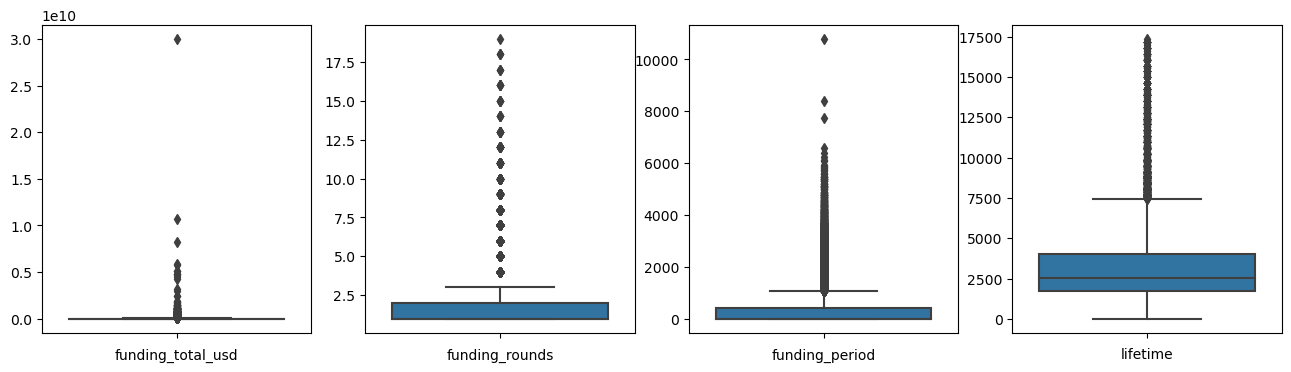

In [101]:
draw_boxplots(startups_train, ['funding_total_usd', 'funding_rounds', 'funding_period', 'lifetime'], '')

In [102]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
ohe_columns = ['region', 'category_list']
ord_columns = []
num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'funding_period']

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1037. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


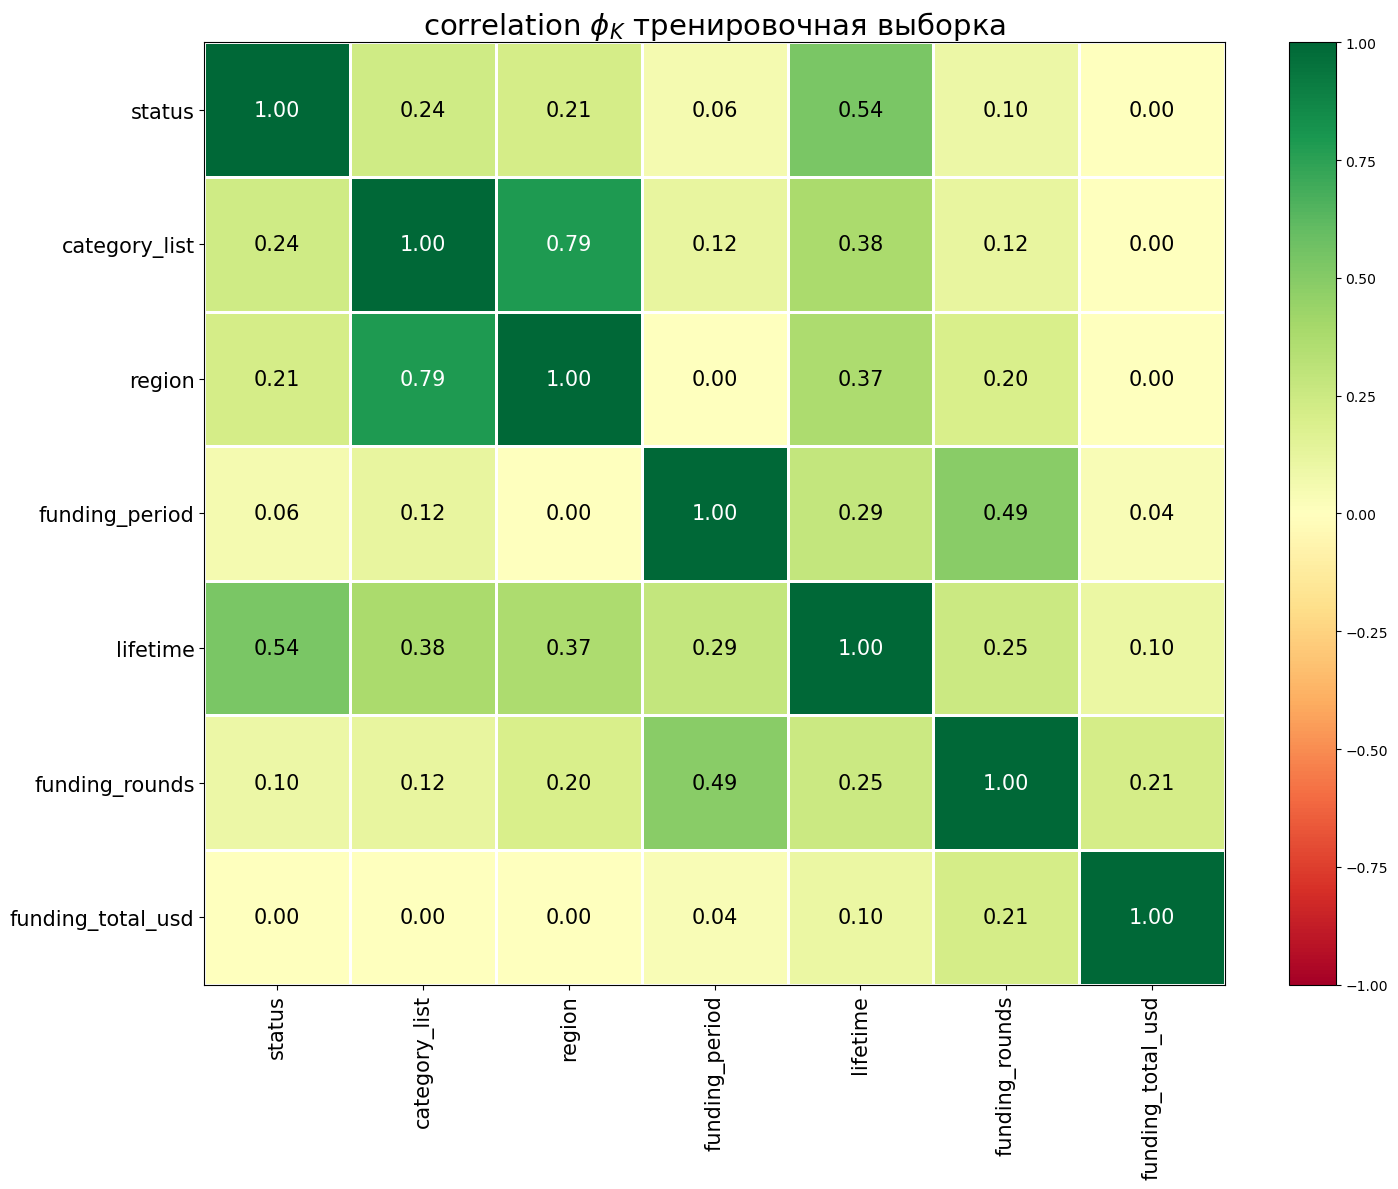

In [103]:
phik_overview = startups_train[num_columns + ohe_columns + ['status']].phik_matrix(interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    startups_train[ohe_columns+ord_columns+num_columns],
    startups_train['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = startups_train['status'])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39384, 6), (13129, 6), (39384,), (13129,))

In [105]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True))
    ]
)

In [106]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [107]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [108]:
param_grid = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LGBMRegressor()
    # {
    #     'models': [lgb.LGBMRegressor()],
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    # }
]

In [109]:
rand_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=-1
)
rand_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rand_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', rand_search.best_score_)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.95086508 0.95086508 0.95086508 0.95085111
 0.95085111 0.95085111 0.95087906 0.95087906 0.95087906 0.95089303
 0.95089303 0.95089303 0.95087906 0.95087906 0.95087906 0.95087906
 0.95087906 0.95087906 0.95087906 0.95087906 0.95087906 0.95085111
 0.95085111 0.95085111 0.95086509 0.95086509 0.95086509 0.95087906
 0.95087906 0.95087906 0.95092098 0.95092098 0.95092098 0.95089303
 0.95089303 0.95089303 0.95092098 0.95092098 0.95

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['region', 'category_list']),
                                                 ('num', StandardScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                                  

In [110]:
y_test_pred = rand_search.predict(X_test)

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [111]:
print(f"Метрика F1 score на тестовой выборке: {f1_score(y_test, y_test_pred)}")

Метрика F1 score на тестовой выборке: 0.9754047707329131


In [112]:
best_model = rand_search.best_estimator_.named_steps['models']
preprocessor = rand_search.best_estimator_.named_steps['preprocessor']

In [113]:
X_test = preprocessor.transform(startups_test[ohe_columns+ord_columns+num_columns])

C:\Users\Zhenya-PC\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [114]:
predict_status = best_model.predict(X_test)

In [115]:
(
    pd.DataFrame({'name': startups_test['name'], 'status': label_encoder.inverse_transform(predict_status)})
      .to_csv('data/kaggle_startups.csv', index=False)
)